In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

In [3]:
ctf = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]

# Load dataset
train_loader = FromPublic('cifar10', 'train', batch_size=512, num_workers=4, custom_tf=ctf)
test_loader = FromPublic('cifar10', 'test', batch_size=512, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Model
model = SENet18(input_dim=3)

# Learning
runner = Runner(model, train_loader, test_loader, optimizer='adam', loss_fn='focal')

In [ ]:
for _ in range(3): runner.fit_onecycle(1e-3, mixup_alpha=0.4)

In [ ]:
runner.fit_cycle(5, 1e-3, mixup_alpha=0.4)

In [ ]:
runner.save('cam.h5')

In [5]:
runner.load('cam.h5')

In [ ]:
runner.validate()

In [84]:
model

SENet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
      (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [89]:
def print_model(model):
    for i, j in model.named_children():
        try:
            print(i, j.weight.requires_grad)
        except:
            print_model(j)

print_model(model)

conv1 True
bn1 True
bn1 True
conv1 True
bn2 True
conv2 True
fc1 True
fc2 True
bn1 True
conv1 True
bn2 True
conv2 True
fc1 True
fc2 True
bn1 True
conv1 True
bn2 True
conv2 True
0 True
fc1 True
fc2 True
bn1 True
conv1 True
bn2 True
conv2 True
fc1 True
fc2 True
bn1 True
conv1 True
bn2 True
conv2 True
0 True
fc1 True
fc2 True
bn1 True
conv1 True
bn2 True
conv2 True
fc1 True
fc2 True
bn1 True
conv1 True
bn2 True
conv2 True
0 True
fc1 True
fc2 True
bn1 True
conv1 True
bn2 True
conv2 True
fc1 True
fc2 True
linear True


In [23]:
m = nn.Sequential(*list(model.children())[:-2], nn.Conv2d(512, 10, 1), nn.AdaptiveAvgPool2d(1), Flatten())

In [72]:
m[-3].weight.data.require_grad

AttributeError: 'Tensor' object has no attribute 'require_grad'

In [24]:
runner2 = Runner(m, train_loader, test_loader, optimizer='adam', loss_fn='focal')

In [25]:
runner2.fit_onecycle(1e-4, mixup_alpha=0.4)

0.6894695387268066
0.8874

Test set: Average loss: 0.3953


In [26]:
class SaveFeatures:
    def __init__(self, m): 
        self.features = None
        self.hook = m.register_forward_hook(self.hook_fn)    
    
    def hook_fn(self, module, input, output):
        self.features = output
    
    def remove(self):
        self.hook.remove()

In [27]:
x, y = next(iter(test_loader))

In [28]:
x, y = x[None, 1], y[None, 1]
vx = Variable(x.cuda())
print(vx.shape)

torch.Size([1, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


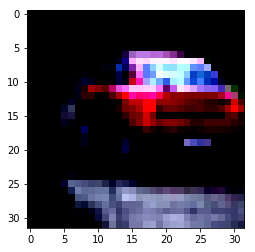

In [29]:
dx = vx.cpu().numpy().transpose(0,2,3,1)[0]
plt.imshow(dx)

In [31]:
sfs = [SaveFeatures(o) for o in [m[-3]]]

In [32]:
py = m(vx)

In [34]:
sfs[0].features.shape

torch.Size([1, 10, 4, 4])

In [35]:
t = sfs[0].features[0].detach().cpu().numpy()
print(t.shape)

(10, 4, 4)


In [36]:
feat = np.maximum(0, t)
feat.shape

(10, 4, 4)

In [37]:
py2 = np.exp(py.detach().cpu().numpy())[0]
print(py2.shape)

(10,)


In [47]:
f2 = np.dot(np.rollaxis(feat,0,3), py2)
f2 -= f2.min()
f2 /= f2.max()
f2

array([[0.        , 0.30894545, 0.27546176, 0.02125465],
       [0.15572251, 0.6992122 , 0.7685757 , 0.39878595],
       [0.2262542 , 0.83890826, 1.        , 0.62250715],
       [0.01932614, 0.3522078 , 0.5101673 , 0.26041043]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


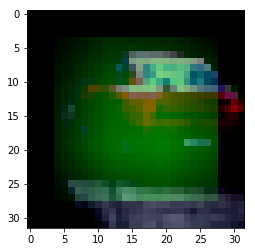

In [62]:
from scipy.misc import imresize 
plt.imshow(dx)
ss = skimage.transform.resize(f2, dx.shape)
plt.imshow(ss, alpha=0.5, cmap='hot')